# Sideboard Guide Generator for MtG

My brother showed me a sideboard guide for his merfolk deck a while ago, which represented cards to side-in and -out for various matchups as a matrix. (the image can be found on patreon [here](https://www.patreon.com/posts/merfolk-decklist-17986130)) This concise way of capturing a lot of information was perfect for creating sideboard guides which can be printed on a standard size game card (63x88mm) and stored in a deckbox along with a deck.


In [38]:
'''Load the data (tabular form) from a text file. The last column (delta) needs to be forced to string 
to keep the plus signs.'''

import pandas as pd

df = pd.read_table('./sideboards.txt', 
                   index_col=['card', 'maindeck'], 
                   dtype={'delta': str}, 
                   skip_blank_lines=True)

df.head()

,,deck,opponent,delta
card,maindeck,,,
Phyrexian Revoker,1,Death and Taxes,Delver,-3
Flickerwisp,1,Death and Taxes,Delver,-1
Sanctum Prelate,1,Death and Taxes,Delver,-1
Path to Exile,0,Death and Taxes,Delver,+1
Rest in Peace,0,Death and Taxes,Delver,+2


In [39]:
'''Select a deck, pivot the table and apply filters'''

deck = "Death and Taxes"

mt = df[df.deck==deck].pivot_table(index=['card', 'maindeck'], 
                                   columns='opponent', 
                                   values='delta', 
                                   fill_value='', 
                                   aggfunc=lambda x: ' '.join(str(v) for v in x)) # Override the aggfunc to work with strings

mt = mt.reset_index()\
       .sort_values(by=['maindeck', 'card'], ascending=[False, True])\
       .drop('maindeck', axis=1)\
       .reset_index(drop=True)

In [27]:
def color_by_value(val):
    '''Function to set text color in pandas'''
    color = 'black'
    try:
        v = int(val)
        color = 'red' if v < 0 else 'green'
    except:
        pass
        
    return 'color: %s' % color

In [40]:
mt.style.applymap(color_by_value)

opponent,card,Death and Taxes,Delver,Dredge,Elves,Infect,Lands,Miracles,Reanimator,Sneak 'n Show,Storm
0,Batterskull,,,,,-1,,,,,
1,Flickerwisp,,-1,,-4,,,,,,-1
2,Mirran Crusader,,,-1,,,-2,,-1,-1,-1
3,Mother of Runes,,,,,,,-4,,,
4,Phyrexian Revoker,,-3,-3,,-3,-3,,-3,,
5,Sanctum Prelate,-1,-1,,,,,,,,
6,Serra Avenger,,,,,,-1,,-1,,-1
7,Spirit of the Labyrinth,-1,,-1,,,-1,,,,
8,Stoneforge Mystic,,,,,,,,-2,-1,
9,Sword of FaI,,,-1,-1,-1,,,-1,,


## Creating an SVG image

Styling tables in pandas and exporting to a format printable in a high resolution is difficult using pandas. To this end we'll use jinja2 and an SVG template to create the final file.

Most of the magic happens in the template **sideboard_guide_template.svg** which will, based on the input, create and position the objects in the SVG file.

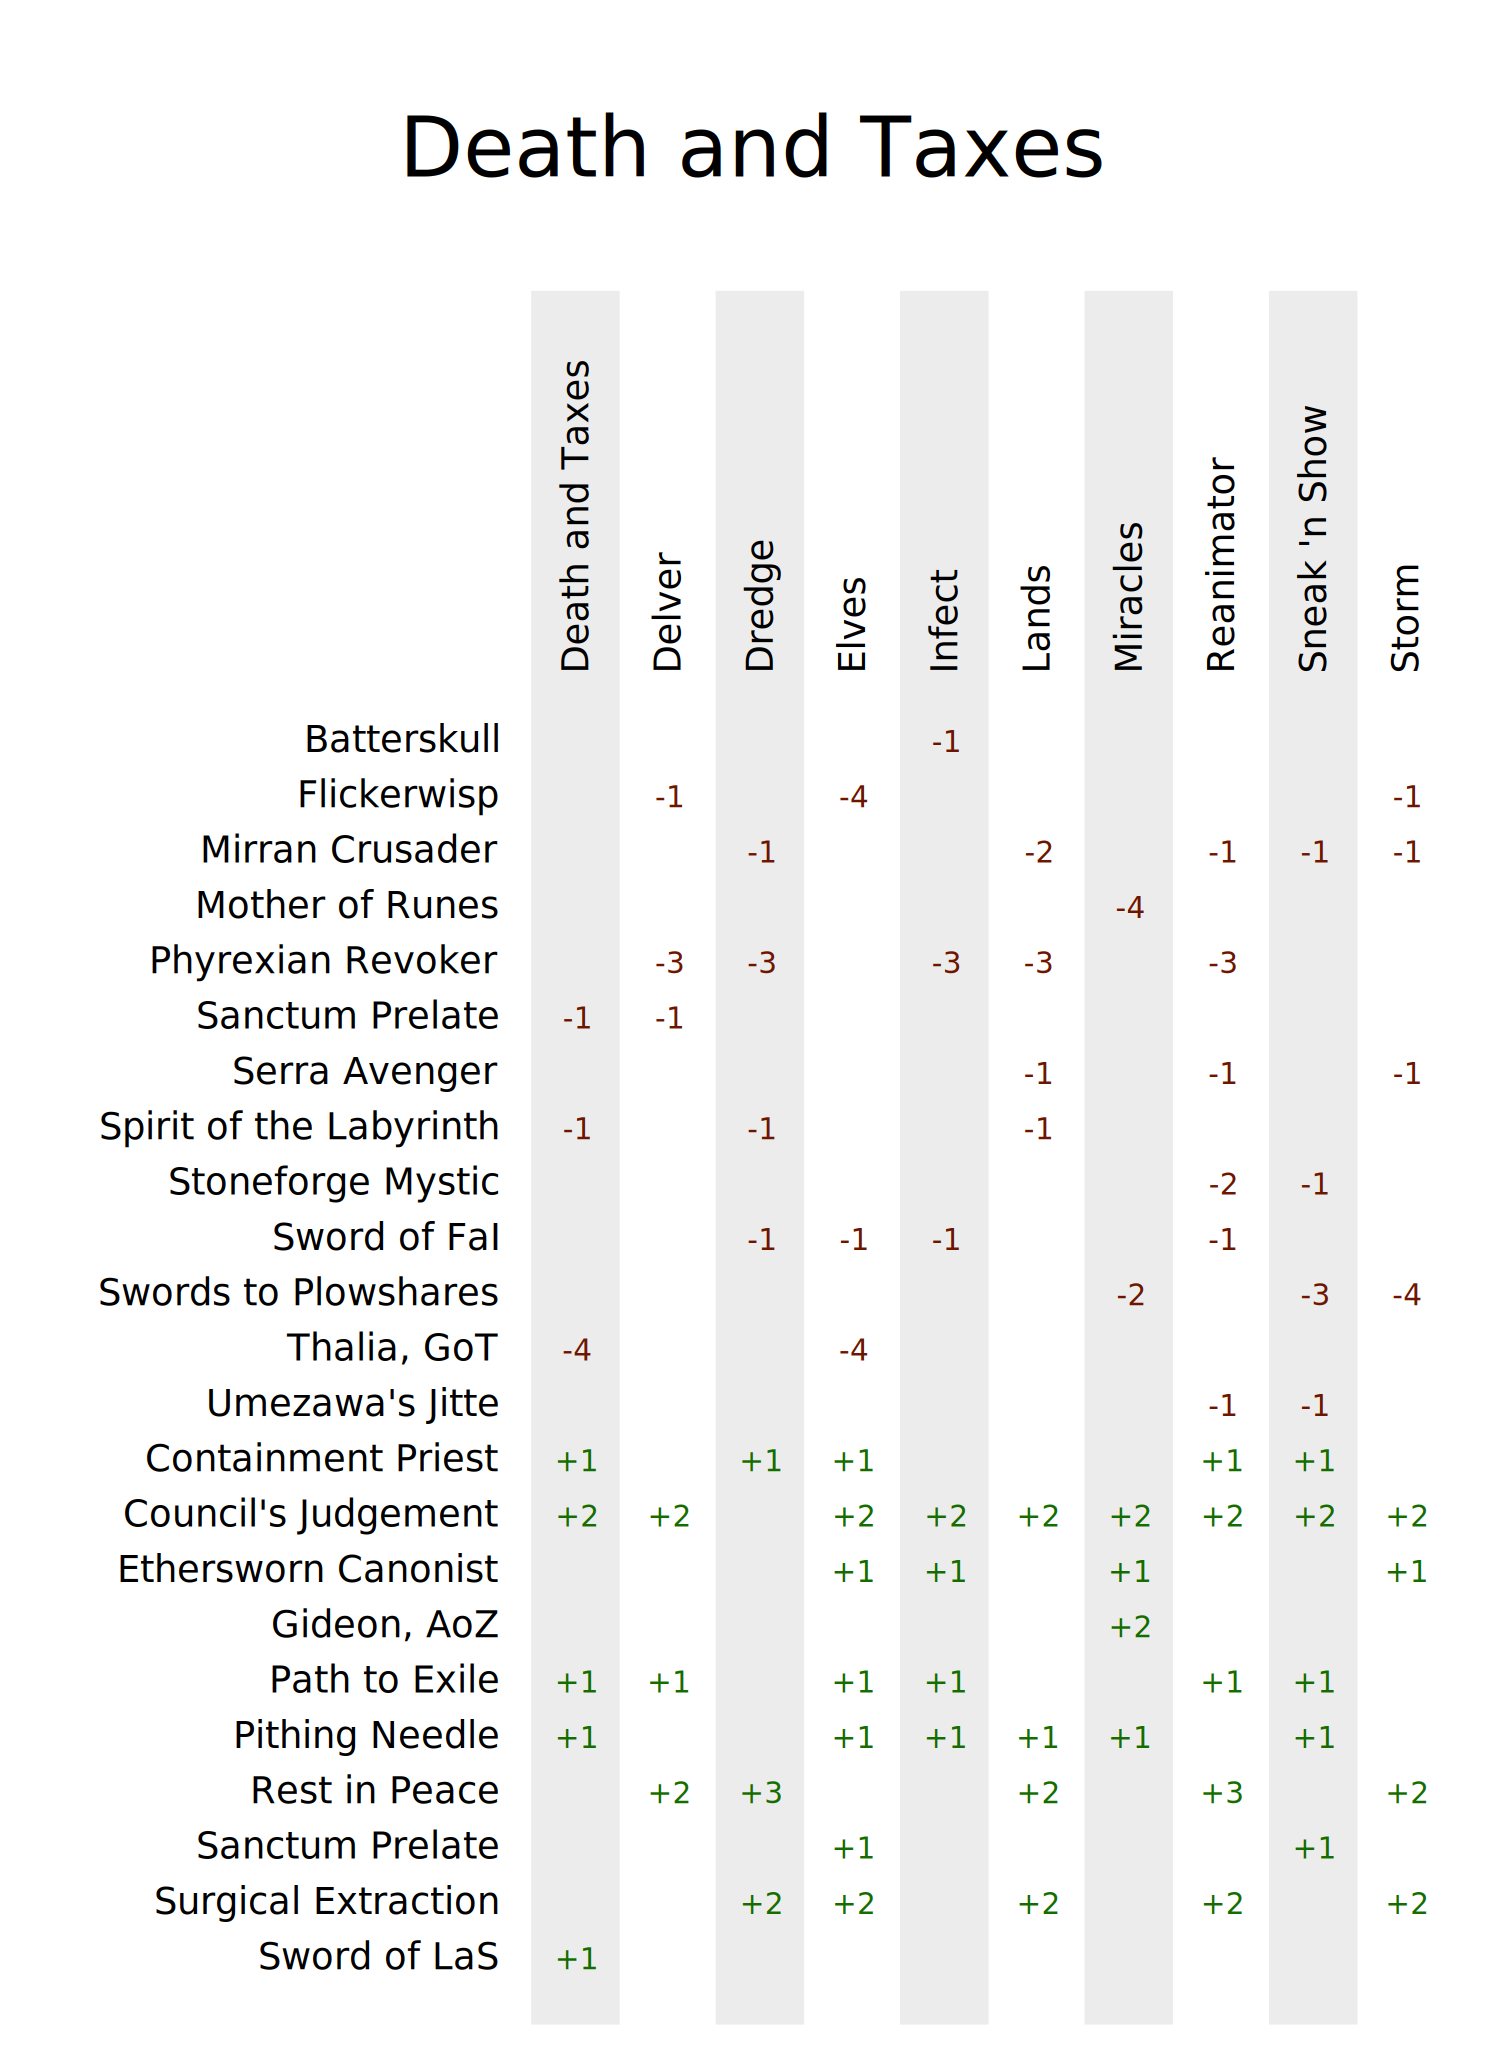

In [42]:
from jinja2 import Environment, FileSystemLoader
from IPython.display import SVG, display

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("sideboard_guide_template.svg")

template_vars = {"deck_title" : deck,
                 "cards": mt['card'].tolist(),
                 "decks": mt.columns.values.tolist()[1:],  # Using slice to exclude the column 'cards'
                 "data": mt.to_dict(),                     # Deck name will be the index
                }

svg_out = template.render(template_vars)

with open('output/' + deck + '_guide.svg', 'w') as fout:
    print(svg_out, file=fout)

display(SVG(data=svg_out))